In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    #for filename in filenames:
    #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/headfc
/kaggle/input/headfc/TestSet
/kaggle/input/fetal-head-thesis
/kaggle/input/fetal-head-thesis/test_set
/kaggle/input/fetal-head-thesis/test_set/test_set
/kaggle/input/fetal-head-thesis/training_set
/kaggle/input/fetal-head-thesis/training_set/training_set
/kaggle/input/modelhc


## code data

https://www.kaggle.com/code/michaelscheinfeilda/vgg-16-fc/edit
https://github.com/michaelscheinfeild/UltraSound/tree/main/DetectHCA
https://github.com/michaelscheinfeild/unetPytorch/blob/main/DeepLearningwithPyTorch_ImageSegmentation(1).ipynb

## imports

In [2]:
%%capture
!pip install segmentation-models-pytorch

In [3]:

import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import scipy.ndimage as nd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import shutil

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
import torch
import torch.nn as nn

In [8]:
from torch.utils.data import Dataset

In [9]:
from torch.utils.data import DataLoader

In [10]:
plt.ion()   # interactive mode

In [11]:
from torch import optim, cuda

In [12]:
# from https://github.com/parth1620/Human-Segmentation-Dataset-master/blob/master/helper.py
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        

## Configuration

In [13]:

EPOCHS =30#
LR = 0.005#0.003
IMAGE_SIZE=320
BATCH_SIZE=16#32#16

ENCODER = 'efficientnet-b0' #'timm-efficientnet-b0'
WEIGHTS = 'imagenet' # 	imagenet

In [14]:
DEVICE = torch.device("cuda") # :0") we have 2 gpu
DEVICE

device(type='cuda')

In [15]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')

Train on gpu: True
2 gpus detected.


## paths

In [16]:
root_dir='/kaggle/input/fetal-head-thesis/training_set/training_set/'
csv_file='/kaggle/input/fetal-head-thesis/training_set_pixel_size_and_HC.csv'

# Data Analysis & Manipulation

In [17]:
HC_df=pd.read_csv(csv_file)
HC_df.head()

filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81

### view image and mask

In [18]:
row = HC_df.iloc[3]
fname = row['filename']
print(fname)

003_HC.png


Text(0.5, 1.0, '003_HC.png')

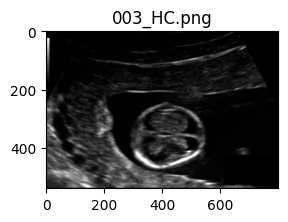

In [19]:
image= cv2.imread(os.path.join(root_dir,fname),cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(3,3))
plt.imshow(image,cmap='gray')
plt.title(fname)

In [20]:
image.shape

(540, 800)

In [21]:
#get mask by image name
def getMaskName(current_filename):
    # Create the new filename
    new_filename = current_filename.replace(".png", "_Annotation.png")
    
    return new_filename

In [22]:
makName = getMaskName(fname)
makName

'003_HC_Annotation.png'

Text(0.5, 1.0, '003_HC.png')

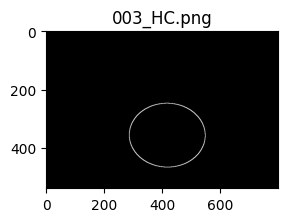

In [23]:
mask= cv2.imread(os.path.join(root_dir,getMaskName(fname)),cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(3,3))
plt.imshow(mask,cmap='gray')
plt.title(fname)

In [24]:
mask.shape

(540, 800)

### mask on image

In [25]:
def plot_MaskOnImage(image,mask):
    #mask image has 1 channel
    if image.shape == mask.shape:
       
        # Create a 3-channel image for overlaying
        overlay = cv2.merge([image, image, image])

        # Create a binary mask for red color where the original mask is non-zero
        red_mask = cv2.merge([ np.zeros_like(mask), np.zeros_like(mask),mask])

        # Add the red mask as an overlay to the image
        cv2.addWeighted(overlay, 1, red_mask, 0.3, 0, overlay)

        plt.figure(figsize=(4,4)) 
        # Display the result using Matplotlib
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.axis('off')

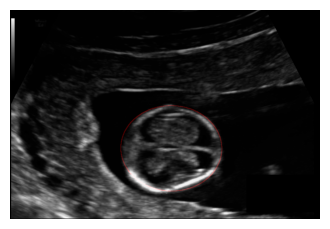

In [26]:
plot_MaskOnImage(image,mask)

In [27]:
#get image and mask  from train
def getTrainImageAndMaks(df,idx):
    
     row   =  df.iloc[idx]
     fname = row['filename']
     #i have bug here but it works neeeded to read as gray ... need cv2.IMREAD_GRAYSCALE
     image= cv2.imread(os.path.join(root_dir,fname),cv2.COLOR_BGR2GRAY)
     mask= cv2.imread(os.path.join(root_dir,getMaskName(fname)),cv2.COLOR_BGR2GRAY)
        
     maskfilled = nd.binary_fill_holes(mask).astype('uint8')*255   
    
     return image,maskfilled
    

In [28]:
print(cv2.COLOR_BGR2GRAY)
print(cv2.IMREAD_GRAYSCALE)

6
0


(540, 800)
(540, 800)


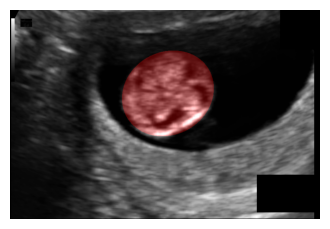

In [29]:
image,mask = getTrainImageAndMaks(HC_df,13)
print(image.shape)
print(mask.shape)
plot_MaskOnImage(image,mask)


### chek fill image

In [30]:
mask.dtype

dtype('uint8')

In [31]:
#maskfilled = nd.binary_fill_holes(mask).astype('uint8')*255

In [32]:
#plt.figure(figsize=(3,3))
#plt.imshow(maskfilled,cmap='gray')

In [33]:
#maskfilled.dtype

In [34]:
#maskfilled.max()

In [35]:
#plot_MaskOnImage(image,maskfilled)

## Split Data

In [36]:
train_df, test_val = train_test_split(HC_df, test_size = 0.3,random_state = 2020)
valid_df, test_df = train_test_split(test_val, test_size = 0.5,random_state = 2020)

print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])
HC_df.describe()

train 699 validation 150 Test 150


pixel size(mm)  head circumference (mm)
count      999.000000               999.000000
mean         0.139846               174.383093
std          0.053005                65.282061
min          0.049415                44.300000
25%          0.108801               153.600000
50%          0.128357               174.060000
75%          0.157678               189.825000
max          0.393280               346.400000

## Augmentations

In [37]:
import albumentations as A

In [38]:
def get_train_augs():
   return A.Compose([
     A.Resize(IMAGE_SIZE,IMAGE_SIZE) ,
     A.HorizontalFlip(p=0.5)  ])
     #A.VerticalFlip(p=0.5),
     #A.Rotate(limit=45, p=0.5),
     #A.RandomBrightnessContrast(p=0.2),
     #A.RandomGamma(p=0.2),
     #A.ElasticTransform(p=0.2),
     #A.GaussNoise(p=0.2)])
     #A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0)])

def get_valid_augs():
  return A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE)])

In [39]:
# Apply the augmentations to your images and masks
def apply_train_augmentations(image, mask):
    augs = get_train_augs()
    augmented = augs(image=image, mask=mask)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']
    return augmented_image, augmented_mask

# DataSet

In [40]:
class SegmentationDataSet(Dataset):

   def __init__(self,df,augmentations):
       self.df = df
       self.augmentations = augmentations

   def __len__(self):
      return len(self.df)

   def __getitem__(self,idx):

    row = self.df.iloc[idx]
    #print("idx {idx}")
    #print(row)

    image,mask = getTrainImageAndMaks(self.df,idx)
    
    if 0:
        plt.figure()
        plt.imshow(image,cmap='gray')
        plt.title('orgimage')

        plt.figure()
        plt.imshow(mask,cmap='gray')
        plt.title('ogmask')
    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    mask = np.expand_dims(mask,axis=-1)#h,w,c
    


    #dictionary
    if (self.augmentations):

  
      augmented = self.augmentations(image=image,mask=mask)

      augmentedImage = augmented['image']
      augmentedMask = augmented['mask']

      #(h,w,c)-> (c,w,h)

      augmentedImage = np.transpose( augmentedImage,(2, 0, 1)).astype(np.float32)
      augmentedMask = np.transpose(augmentedMask,(2, 0, 1)).astype(np.float32)

      augmentedImage = torch.Tensor(augmentedImage)/255.0
      augmentedMask  = torch.round(torch.Tensor(augmentedMask)/255.0)

      return augmentedImage,augmentedMask

In [41]:
trainset = SegmentationDataSet(train_df, get_train_augs())
validset = SegmentationDataSet(valid_df, get_valid_augs())
testset  = SegmentationDataSet(test_df, get_valid_augs())

In [42]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")
print(f"Size of Testset : {len(testset)}")

Size of Trainset : 699
Size of Validset : 150
Size of Testset : 150


In [43]:
vTrain0=trainset[0]

In [44]:
train_df.iloc[0]

filename                   690_2HC.png
pixel size(mm)                0.177534
head circumference (mm)          263.5
Name: 849, dtype: object

In [45]:
def checkImageLoc(image):
    if image.device.type == 'cpu':
      print("Image is on the CPU.")
    else:
      print("Image is on the GPU.")

In [46]:
def getImageMakPlot(image,mask):
       
    imageP=image.squeeze(0)
    imagePT = ((np.transpose( imageP,(1, 2, 0)).numpy())*255).astype(np.uint8)
    grayscale_image = cv2.cvtColor(imagePT, cv2.COLOR_BGR2GRAY)
    
    maskP=mask.squeeze(0)
    maskPT = ((np.transpose( maskP,(1, 2, 0)).numpy())*255).astype(np.uint8)[:,:,0]
   
    
    return grayscale_image,maskPT

Size of Trainset : 699
Size of Validset : 150


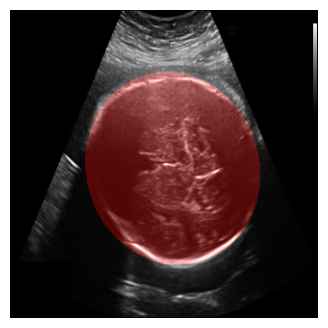

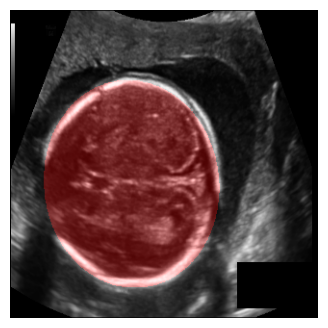

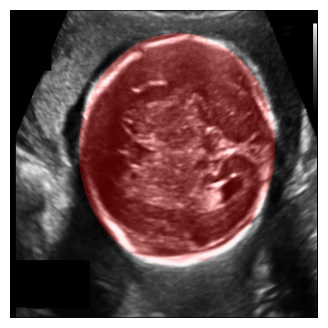

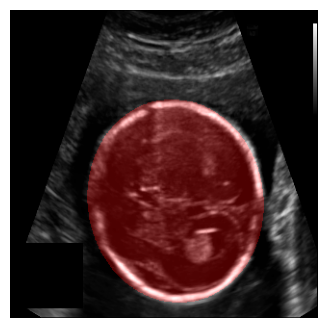

In [47]:
# Create a DataLoader to iterate over your trainset
dataloader = DataLoader(trainset, batch_size=1, shuffle=True)
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")


for i, (image, mask) in enumerate(dataloader):
    if i == 4:
        break  # Stop after loading 4 objects
 
    imagePT, maskPT = getImageMakPlot(image,mask)
    plot_MaskOnImage(imagePT, maskPT)
    

In [48]:
'''
# Convert the image to a NumPy array and scale to [0, 255]
image_np = (image.squeeze(0).cpu().numpy() * 255).astype('uint8')

# Convert the RGB image to grayscale
gray_image = image_np.mean(axis=0)

# Plot the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
'''

"\n# Convert the image to a NumPy array and scale to [0, 255]\nimage_np = (image.squeeze(0).cpu().numpy() * 255).astype('uint8')\n\n# Convert the RGB image to grayscale\ngray_image = image_np.mean(axis=0)\n\n# Plot the grayscale image\nplt.imshow(gray_image, cmap='gray')\nplt.axis('off')  # Turn off axis labels\n"

In [49]:
'''
fname = '396_HC.png'
imagechk= cv2.imread(os.path.join(root_dir,fname),cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(imagechk,cmap='gray')
plt.title(fname)
'''

"\nfname = '396_HC.png'\nimagechk= cv2.imread(os.path.join(root_dir,fname),cv2.COLOR_BGR2GRAY)\nplt.figure()\nplt.imshow(imagechk,cmap='gray')\nplt.title(fname)\n"

In [50]:
'''
fname =  '444_HC_Annotation.png'
mask= cv2.imread(os.path.join(root_dir,fname),cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(4,4))
plt.imshow(mask,cmap='gray')
plt.title(fname)
'''

"\nfname =  '444_HC_Annotation.png'\nmask= cv2.imread(os.path.join(root_dir,fname),cv2.COLOR_BGR2GRAY)\nplt.figure(figsize=(4,4))\nplt.imshow(mask,cmap='gray')\nplt.title(fname)\n"

In [51]:
if 0:
    maskfilled = nd.binary_fill_holes(mask).astype('uint8')*255
    mask= cv2.imread(os.path.join(root_dir,fname),cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(4,4))
    plt.imshow(maskfilled,cmap='gray')
    plt.title(fname)

## Load dataset into batches

In [52]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validationloader = DataLoader(validset,batch_size=BATCH_SIZE)
testloader = DataLoader(testset,batch_size=BATCH_SIZE)

In [53]:
print(f"batches train:{len(trainloader)}")
print(f"batches validation:{len(validationloader )}")
print(f"batches test:{len(testloader )}")

batches train:44
batches validation:10
batches test:10


In [54]:
for imageb,maskb in trainloader:
  break

print(f"image batch:{imageb.shape}")
print(f"mask batch:{maskb.shape}")

image batch:torch.Size([16, 3, 320, 320])
mask batch:torch.Size([16, 1, 320, 320])


## Create Segmentation Model

In [55]:
import segmentation_models_pytorch as smp

In [56]:
from segmentation_models_pytorch.losses  import DiceLoss

In [57]:
class SegmentationModel(nn.Module): #nn.Module
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None #output logit
    )

  def forward(self, images, masks=None):
    
    logits = self.arc(images)
    
    if masks is not None:
        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1 + loss2
    else:
        return logits
    
    
    '''
     logits = self.arc(images)

     loss1=DiceLoss(mode='binary')(logits,masks)
     loss2=nn.BCEWithLogitsLoss()(logits,masks)
     return logits,loss1+loss2
    '''

In [58]:
model=SegmentationModel();
model.to(DEVICE);

model.eval();



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 151MB/s]


# Create Train and Validation Function

In [59]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in data_loader:

        images=images.to(DEVICE)
        masks=masks.to(DEVICE)

        optimizer.zero_grad()

        logits,loss = model(images,masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [60]:
def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
      for images, masks in data_loader:

          images=images.to(DEVICE)
          masks=masks.to(DEVICE)

          logits,loss = model(images,masks)

          total_loss += loss.item()

    return total_loss/len(data_loader)

## Train Model

In [61]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [62]:
def calculate_accuracy(logits, masks):
    # Apply a threshold to the logits to get binary predictions (0 or 1)
    binary_predictions = (logits > 0).float()  # Adjust the threshold as needed

    # Calculate accuracy by comparing predictions to ground truth masks
    correct_predictions = (binary_predictions == masks).float()
    accuracy = correct_predictions.mean().item()
    return accuracy

In [63]:
best_valid_loss = np.inf
train_losses = []
valid_losses = []
#train_accuracies = []
#valid_accuracies = []
patience = 5
consecutive_no_improvement = 0

for i in range(EPOCHS):
    train_loss =  train_fn(trainloader,model,optimizer) #moves inside images to device
    valid_loss  = eval_fn(validationloader,model)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    #train_accuracy = 0.0
    #for images, masks in trainloader:
    #    logits, _ = model(images)   #move to device
    #    train_accuracy += calculate_accuracy(logits, masks)
    #train_accuracy /= len(trainloader)

    # Calculate validation accuracy
    #valid_accuracy = 0.0
    #for images, masks in validationloader:
    #    logits, _ = model(images)
    #    valid_accuracy += calculate_accuracy(logits, masks)
    #valid_accuracy /= len(validationloader)


    #train_accuracies.append(train_accuracy)
    #valid_accuracies.append(valid_accuracy)

    if(valid_loss<best_valid_loss):
      torch.save(model.state_dict(),'best_model.pt')
      print("saved_model")
      best_valid_loss = valid_loss
      consecutive_no_improvement = 0
    else:
      consecutive_no_improvement += 1

    
    print(f"Epoch: {i}  , train_loss: {train_loss}  , valid_loss: {valid_loss}")
    
    if consecutive_no_improvement >= patience:
            print(f"Early stopping triggered at epoch {i + 1} as early_stopping_metric did not improve.")
            break

  

saved_model
Epoch: 0  , train_loss: 0.30184483087875624  , valid_loss: 4.792292642593384
saved_model
Epoch: 1  , train_loss: 0.11155492930927059  , valid_loss: 0.8754377901554108
Epoch: 2  , train_loss: 0.10078733363612132  , valid_loss: 1.6886725664138793
Epoch: 3  , train_loss: 0.09450170584022999  , valid_loss: 1.210083919763565
saved_model
Epoch: 4  , train_loss: 0.1000683048570698  , valid_loss: 0.16953233778476715
Epoch: 5  , train_loss: 0.08240182926370339  , valid_loss: 0.20503446012735366
Epoch: 6  , train_loss: 0.07945048851384358  , valid_loss: 0.17515677213668823
saved_model
Epoch: 7  , train_loss: 0.07366009386764331  , valid_loss: 0.14545174166560174
Epoch: 8  , train_loss: 0.07062683855606751  , valid_loss: 0.1569446213543415
Epoch: 9  , train_loss: 0.07607287625697526  , valid_loss: 0.2112833008170128
Epoch: 10  , train_loss: 0.07653138642622666  , valid_loss: 0.1483061984181404
Epoch: 11  , train_loss: 0.07349470460956747  , valid_loss: 0.20380128622055055
Epoch: 12  ,

### Plot training

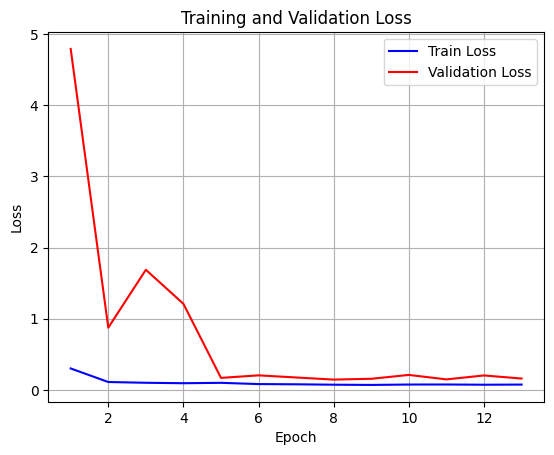

In [64]:
# Create a list of epochs (e.g., [1, 2, 3, ...]) for the x-axis
epochs = list(range(1, len(train_losses) + 1))

# Plot training loss in blue and validation loss in red
plt.plot(epochs[0:], train_losses[0:], label='Train Loss', color='blue')
plt.plot(epochs[0:], valid_losses[0:], label='Validation Loss', color='red')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()

## Inference

In [65]:
model.load_state_dict(torch.load('best_model.pt'));

idx=20
image,mask=validset[idx]

In [66]:
model.eval();

In [67]:
with torch.no_grad():
      for images, masks in validationloader:

          images=images.to(DEVICE)
          masks=masks.to(DEVICE)

          logits,loss = model(images,masks)
          break

In [68]:
from sklearn.metrics import jaccard_score

In [69]:
def convert_and_plot(image, mask, pred_mask):
    # Convert torch tensors to numpy arrays and scale to [0, 255]
    image_np = (image.squeeze(0).cpu().numpy() * 255).astype('uint8')
    mask_np = (mask.squeeze(0).cpu().numpy() * 255).astype('uint8')
    pred_mask_np = (pred_mask.squeeze(0).cpu().numpy() * 255).astype('uint8')
    
    #-----
    image_np  = image_np.transpose(1, 2, 0)

    # Create overlays
    overlay_mask = cv2.addWeighted(image_np, 0.7, cv2.merge([mask_np, np.zeros_like(mask_np), np.zeros_like(mask_np)]), 0.3, 0)
    overlay_pred_mask = cv2.addWeighted(image_np, 0.7, cv2.merge([pred_mask_np, np.zeros_like(pred_mask_np), np.zeros_like(pred_mask_np)]), 0.3, 0)
    overlay_combined = cv2.addWeighted(overlay_pred_mask, 0.5, cv2.merge([mask_np, pred_mask_np, np.zeros_like(pred_mask_np)]), 0.5, 0)

    # Calculate IOU (Jaccard Index) between masks
    iou = jaccard_score(mask_np.flatten(), pred_mask_np.flatten(),pos_label=255.0)
    
    # Plot overlays
    plt.figure()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(overlay_mask)
    axes[0].set_title('Mask Overlay')
    axes[1].imshow(overlay_pred_mask)
    axes[1].set_title('Predicted Mask Overlay')
    axes[2].imshow(overlay_combined)
    axes[2].set_title(f'Combined Overlay (IoU = {iou:.4f})')
    for ax in axes:
        ax.axis('off')

  

    print(f"IoU between masks: {iou:.4f}")

IoU between masks: 0.9413
IoU between masks: 0.9662
IoU between masks: 0.9501
IoU between masks: 0.9603
IoU between masks: 0.9721
IoU between masks: 0.9242


/tmp/ipykernel_26/814530038.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))


IoU between masks: 0.9579
IoU between masks: 0.9549
IoU between masks: 0.9600
IoU between masks: 0.9568
IoU between masks: 0.9348
IoU between masks: 0.9720
IoU between masks: 0.9618
IoU between masks: 0.9465
IoU between masks: 0.9732
IoU between masks: 0.9176


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

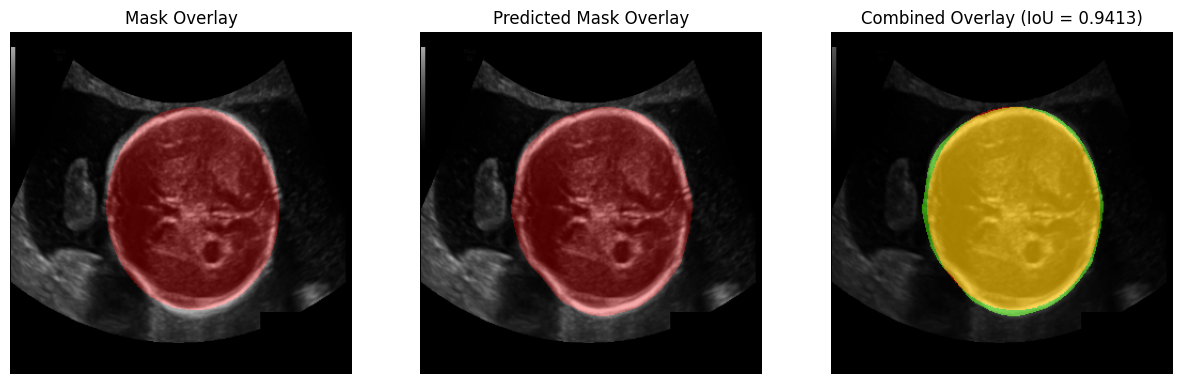

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

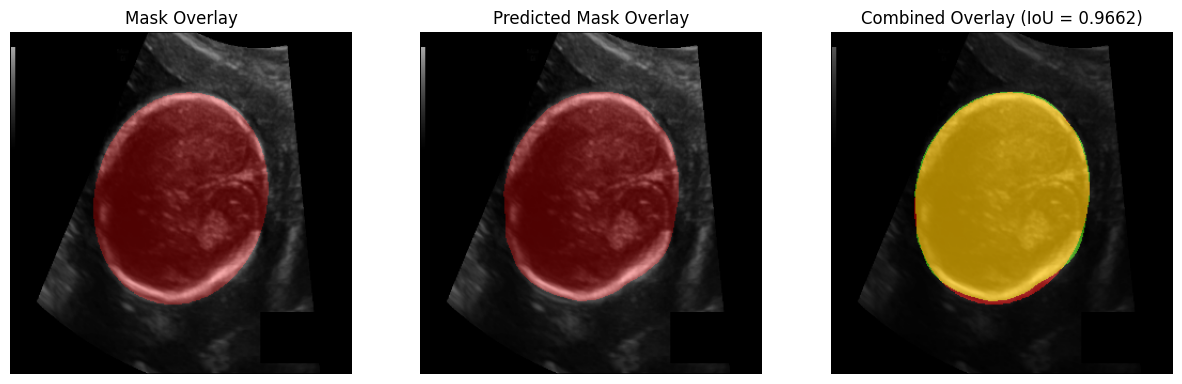

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

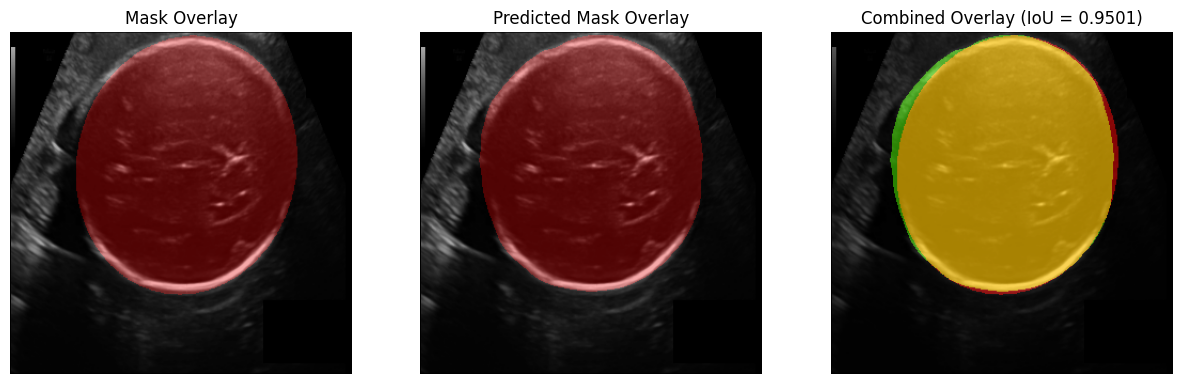

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

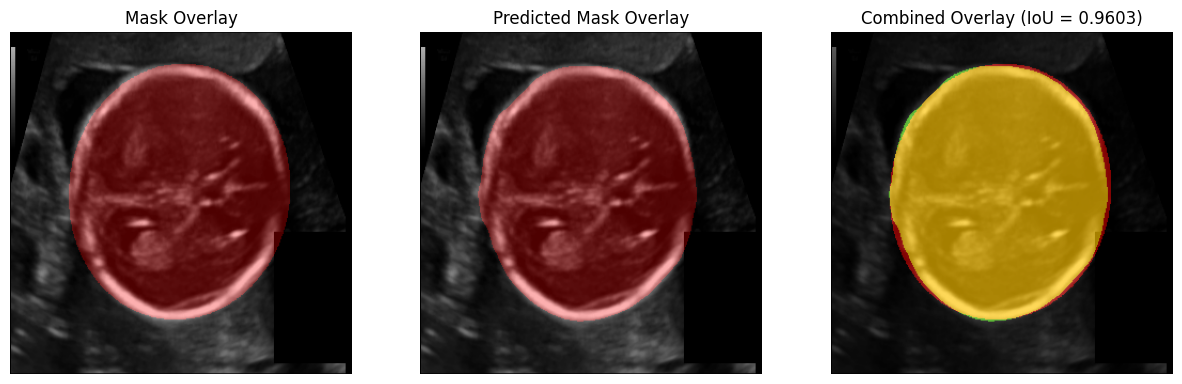

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

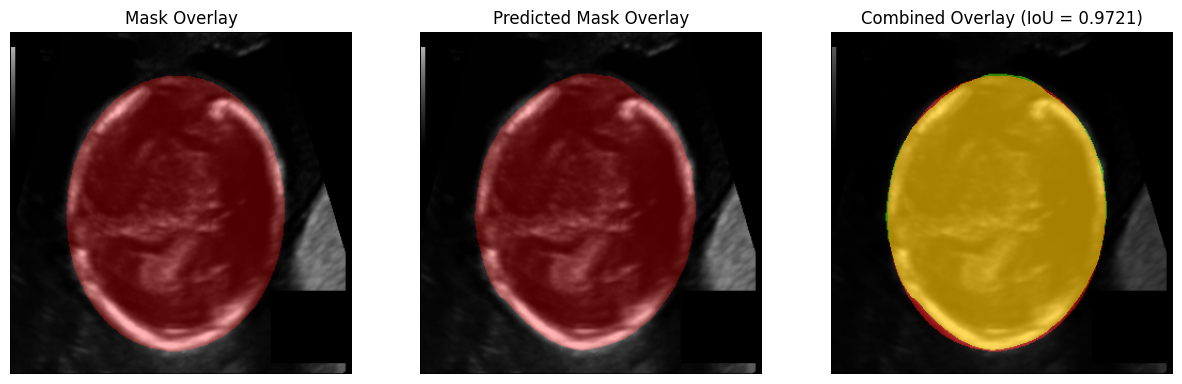

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

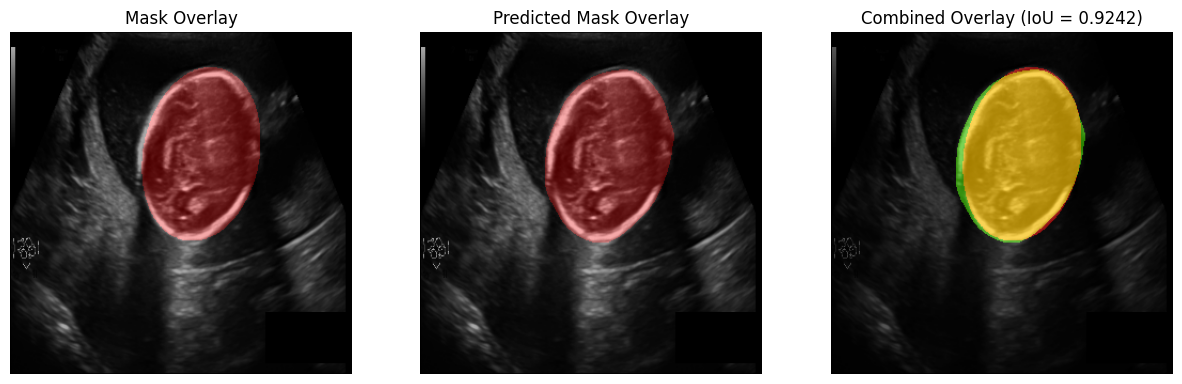

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

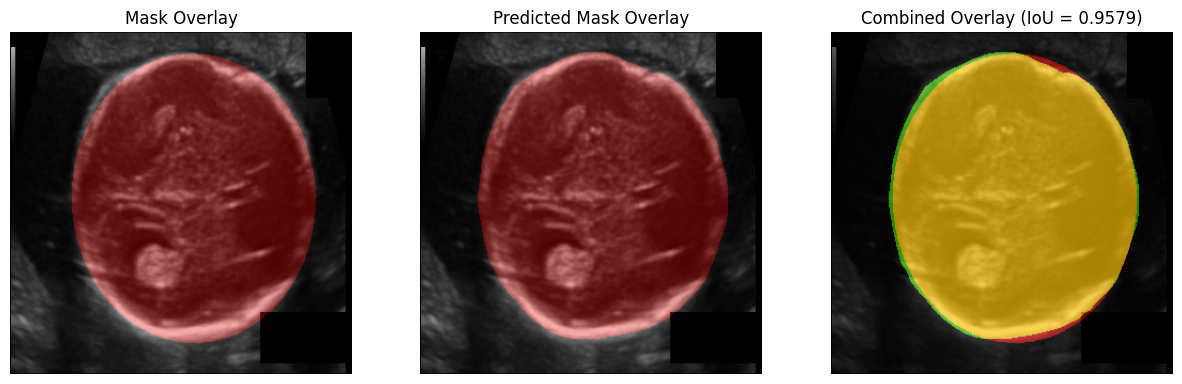

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

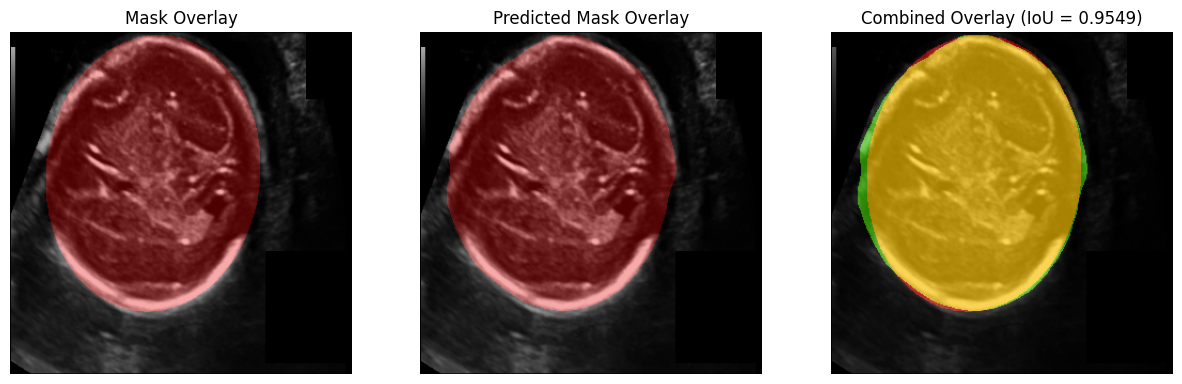

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

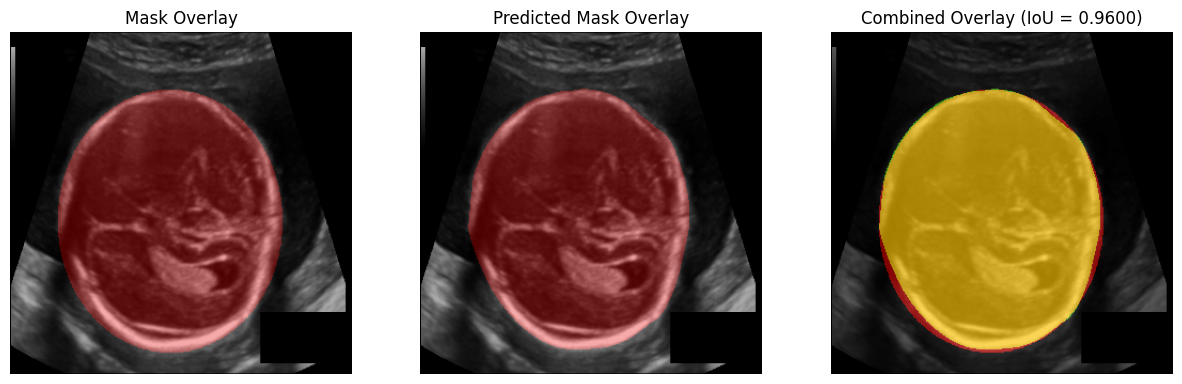

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

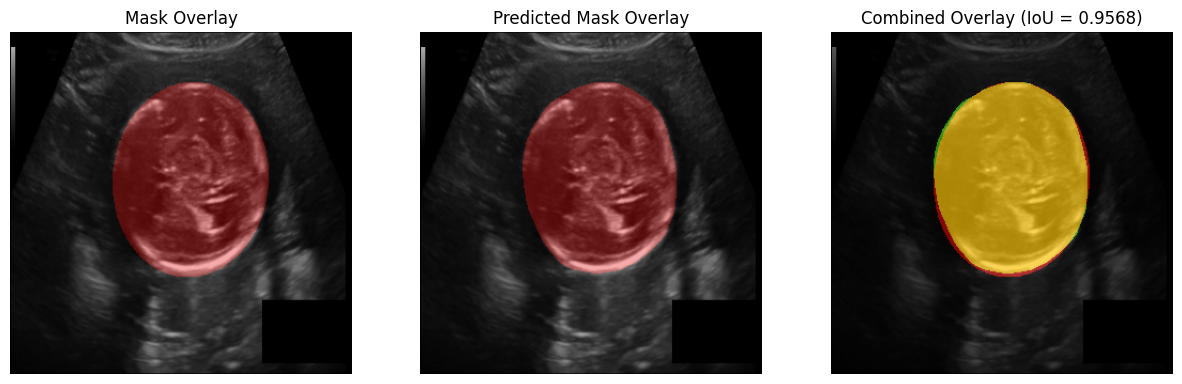

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

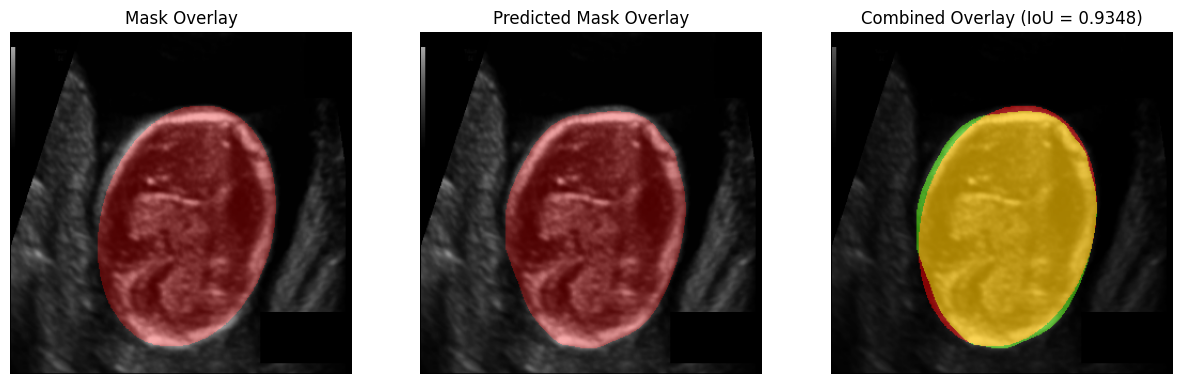

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

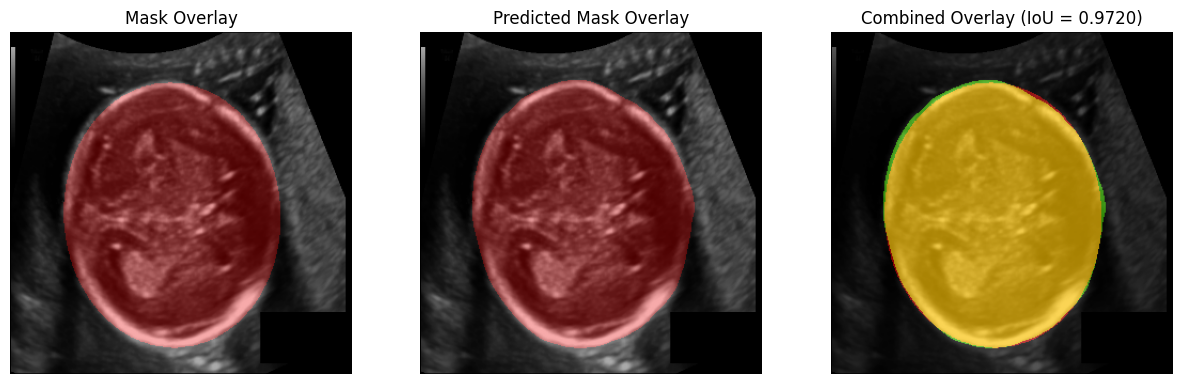

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

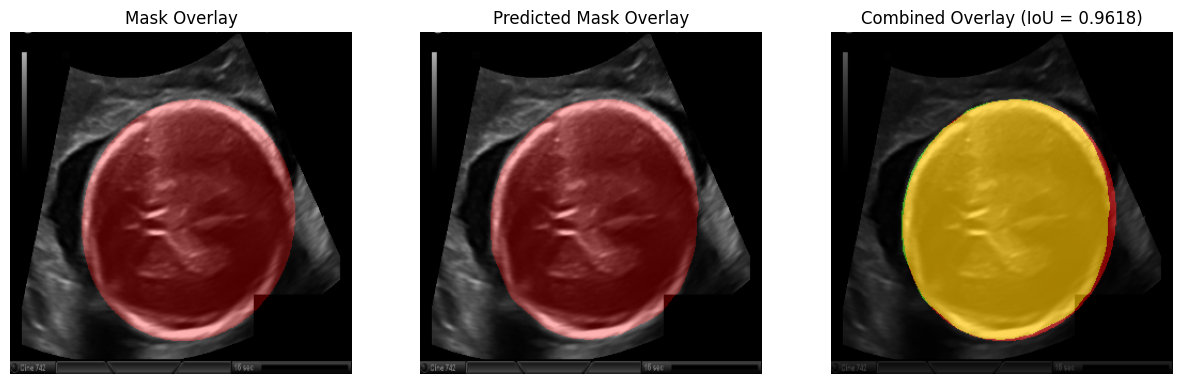

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

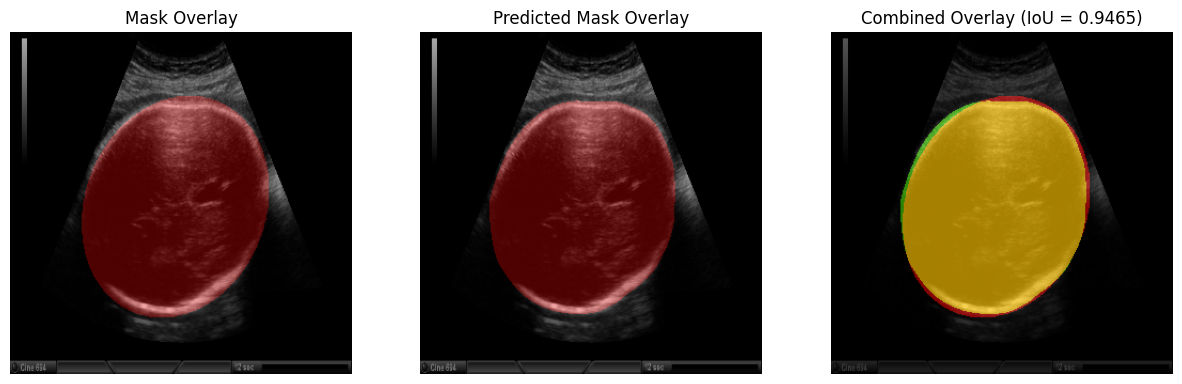

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

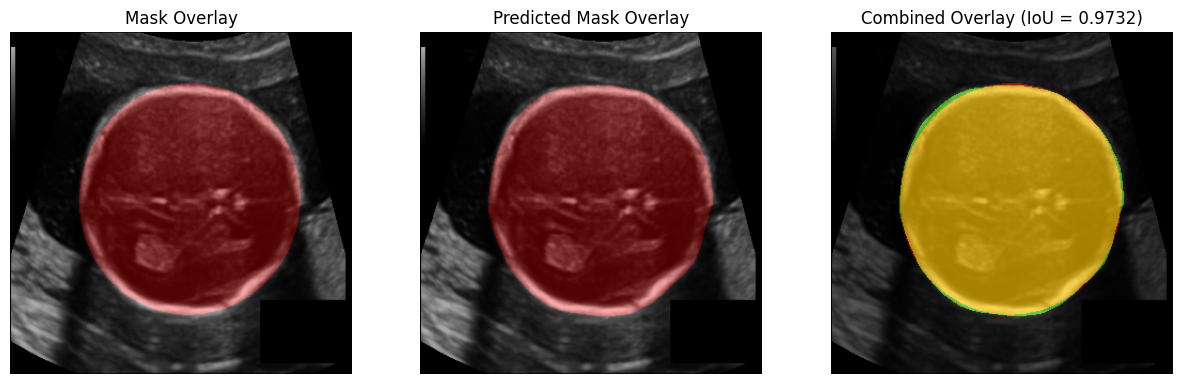

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

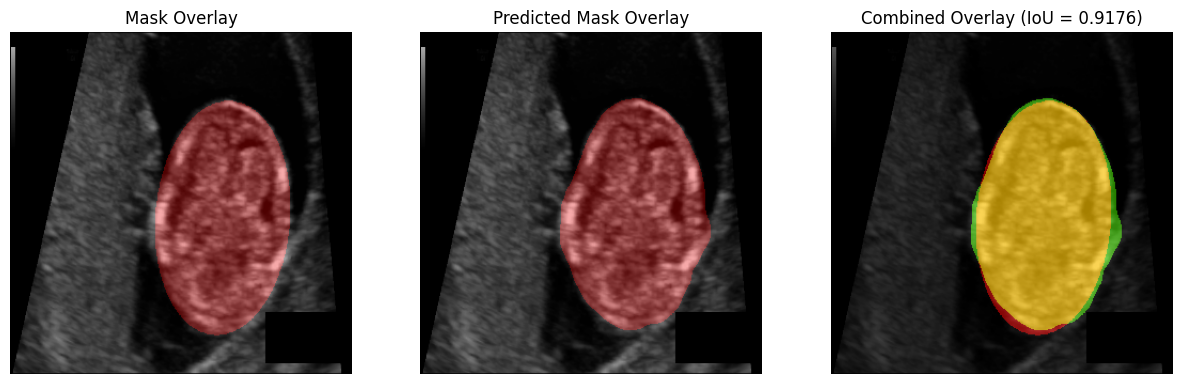

In [70]:
for i in range(BATCH_SIZE):
    plt.figure()
    img_cpu = images[i].cpu()
    mask_cpu = masks[i].cpu()
    logits_mask_cpu = logits[i].cpu()

    pred_mask = torch.sigmoid(logits_mask_cpu)
    pred_mask = (pred_mask > 0.5).float()

    # Perform some operations with img_cpu, mask_cpu, and pred_mask on the CPU
    # For example, you can call a function with these tensors
    #helper.show_image(img_cpu, mask_cpu, pred_mask)
    convert_and_plot(img_cpu, mask_cpu, pred_mask)
    
    #break

#test new images

In [71]:
pathtestExternal = '/kaggle/input/headfc/TestSet'

In [72]:
image_paths = [os.path.join(pathtestExternal, image_file) for image_file in os.listdir(pathtestExternal)]
image_paths

['/kaggle/input/headfc/TestSet/image_hc_7.jpg',
 '/kaggle/input/headfc/TestSet/image_hc_104.jpg',
 '/kaggle/input/headfc/TestSet/image_hc_17.jpg',
 '/kaggle/input/headfc/TestSet/image_hc_30.jpg']

In [73]:
from PIL import Image

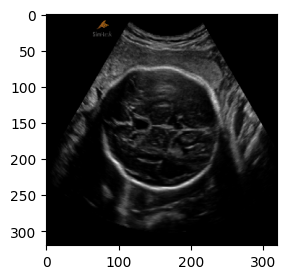

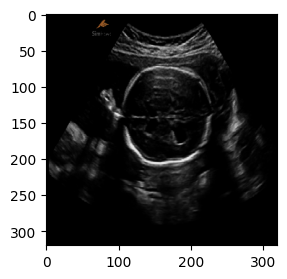

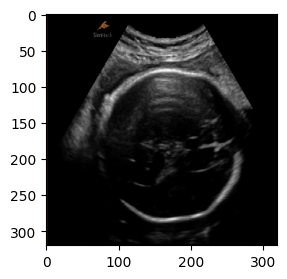

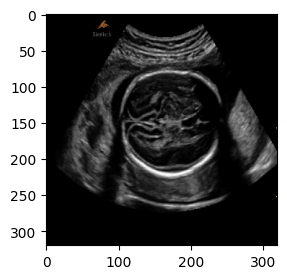

In [74]:
augmentations = get_valid_augs() 
images = []
for image_path in image_paths:
    
    image = cv2.imread(image_path, cv2.COLOR_GRAY2RGB)
    
    
    #image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    #plt.figure(figsize=(3,3))
    #plt.imshow(image,cmap='gray')
    
    #print(';;;;;',image.shape)
    
    #image=np.array(image)
    #Apply augmentations using the defined function
    augmented = augmentations(image=image)['image']
    
   
    plt.figure(figsize=(3,3))
    plt.imshow(augmented,cmap='gray')
    
    #print('augmented;;;;',augmented.shape)
    
    augmentedImage = np.transpose( augmented,(2, 0, 1)).astype(np.float32)
    augmentedImage = torch.Tensor(augmentedImage)/255.0
      
    images.append(augmentedImage)

In [75]:
imagesST = np.stack(images)

In [76]:
imagesST.shape

(4, 3, 320, 320)

In [77]:
#[batch_size, num_channels, height, width]
# Convert the list of images to a torch tensor
#images = np.array(images)
#images = torch.tensor(images).permute(0, 3, 1, 2).to(DEVICE)
#images.shape
#images[0].shape

In [78]:
imagesST = torch.tensor(imagesST).to(DEVICE)

In [79]:
#best_model.pt
model.load_state_dict(torch.load('/kaggle/input/modelhc/best_model.pt'));
model.to(DEVICE);
model.eval();

In [80]:
# Predict masks
with torch.no_grad():
    predicted_masks = model(imagesST)

# Convert predicted masks to numpy arrays
predicted_masks = predicted_masks.cpu().numpy()

In [81]:
'''
#(4, 1, 320, 320)
print(predicted_masks.shape)

mask1=predicted_masks[0].squeeze()
print(mask1.shape)

mask1=(mask1*255.0).astype('uint8')

print(mask1.dtype)
plt.imshow(mask1,cmap='gray')
'''

"\n#(4, 1, 320, 320)\nprint(predicted_masks.shape)\n\nmask1=predicted_masks[0].squeeze()\nprint(mask1.shape)\n\nmask1=(mask1*255.0).astype('uint8')\n\nprint(mask1.dtype)\nplt.imshow(mask1,cmap='gray')\n"

In [82]:
'''
for image_path,mask_np in zip(image_paths,predicted_masks):
    
    image = Image.open(image_path)
    image=np.array(image)
    image = augmentations(image=image)['image']
    
    mask_np = (mask_np.squeeze()*255).astype('uint8')
    
    overlay_mask = cv2.addWeighted(image, 0.7, cv2.merge([mask_np, np.zeros_like(mask_np), np.zeros_like(mask_np)]), 0.3, 0)
    
    plt.figure()
    plt.imshow( overlay_mask)
'''

"\nfor image_path,mask_np in zip(image_paths,predicted_masks):\n    \n    image = Image.open(image_path)\n    image=np.array(image)\n    image = augmentations(image=image)['image']\n    \n    mask_np = (mask_np.squeeze()*255).astype('uint8')\n    \n    overlay_mask = cv2.addWeighted(image, 0.7, cv2.merge([mask_np, np.zeros_like(mask_np), np.zeros_like(mask_np)]), 0.3, 0)\n    \n    plt.figure()\n    plt.imshow( overlay_mask)\n"

#check on img

In [83]:
fname='/kaggle/input/fetal-head-thesis/training_set/training_set/000_HC.png'
image= cv2.imread(fname,cv2.COLOR_BGR2GRAY)

In [84]:
augment = get_valid_augs()

In [85]:
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
augmented = augment(image=image)

augmentedImage = augmented['image']
      

#(h,w,c)-> (c,w,h)

augmentedImage = np.transpose( augmentedImage,(2, 0, 1)).astype(np.float32)
      

augmentedImage = torch.Tensor(augmentedImage)/255.0
      

In [86]:
augmentedImage.shape

torch.Size([3, 320, 320])

In [87]:
image_batch = augmentedImage.unsqueeze(0)
image_batch.shape

torch.Size([1, 3, 320, 320])

In [88]:
image_batch=image_batch.to(DEVICE)

In [89]:
 with torch.no_grad():
    logits= model(image_batch)

In [90]:
logits.shape

torch.Size([1, 1, 320, 320])

In [91]:
logits_mask_cpu = logits[0].cpu()

pred_mask = torch.sigmoid(logits_mask_cpu)
pred_mask = (pred_mask > 0.5).float()

In [92]:
pred_mask.shape

torch.Size([1, 320, 320])

In [93]:
pred_mask = pred_mask[0,:,:]
pred_mask.shape

torch.Size([320, 320])

In [94]:
pred_mask = pred_mask.numpy()

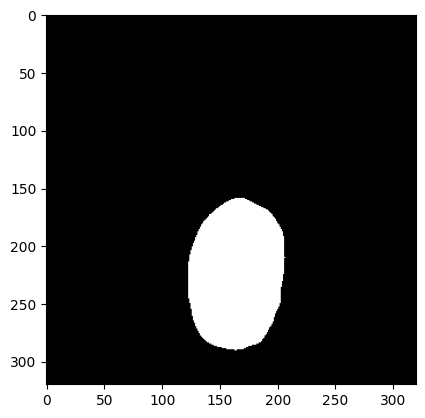

In [95]:
plt.imshow(pred_mask,cmap='gray')

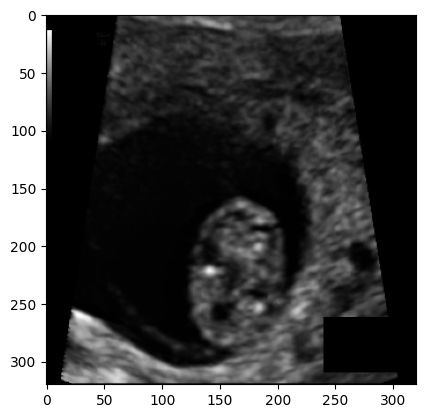

In [96]:
plt.imshow(augmented['image'][:,:,0] ,cmap='gray')

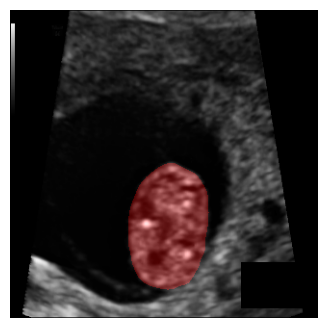

In [97]:
plot_MaskOnImage(augmented['image'][:,:,0], (pred_mask*255).astype('uint8'))

In [98]:
#runs model on 1 image
def runModelOnImage(model,imgPath,augment):
    
    image= cv2.imread(fname,cv2.IMREAD_GRAYSCALE)# COLOR_BGR2GRAY)
    
    hImage,wImage=image.shape
    print(hImage,wImage)
    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    augmented = augment(image=image)

    augmentedImage = augmented['image']
      

    #(h,w,c)-> (c,w,h)

    augmentedImage = np.transpose( augmentedImage,(2, 0, 1)).astype(np.float32)
    augmentedImage = torch.Tensor(augmentedImage)/255.0
    
    # add dimension batch
    image_batch = augmentedImage.unsqueeze(0)
    image_batch=image_batch.to(DEVICE) 
        
    image_batch=image_batch.to(DEVICE)   
    
    
    with torch.no_grad():
        logits= model(image_batch)
        
        
    logits_mask_cpu = logits[0].cpu()

    pred_mask = torch.sigmoid(logits_mask_cpu)
    pred_mask = (pred_mask > 0.5).float() 
    pred_mask = pred_mask[0,:,:].numpy()
        
    masku =  (pred_mask*255).astype('uint8')
    plot_MaskOnImage(augmented['image'][:,:,0], (pred_mask*255).astype('uint8'))   
    

    return masku,hImage,wImage    
    

540 800


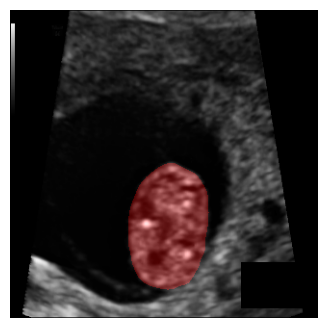

In [99]:
fname='/kaggle/input/fetal-head-thesis/training_set/training_set/000_HC.png'
mask1,hImage,wImage = runModelOnImage(model,fname,get_valid_augs())

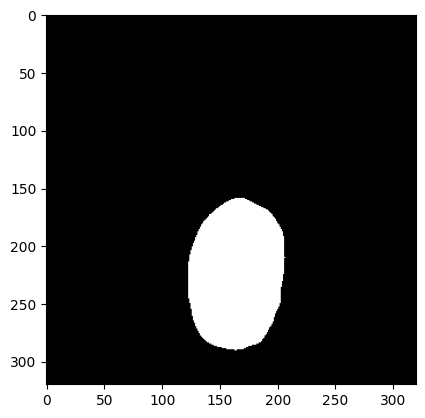

In [100]:
plt.imshow(mask1,cmap='gray')

In [101]:
maskr = cv2.resize(mask1,(wImage,hImage))
maskr.shape

(540, 800)

In [102]:
'''
# Apply edge detection using the Canny edge detector
threshold1 = 20
threshold2 = 255
edges = cv2.Canny(mask1, threshold1, threshold2)

plt.imshow(edges,cmap='gray')
'''

"\n# Apply edge detection using the Canny edge detector\nthreshold1 = 20\nthreshold2 = 255\nedges = cv2.Canny(mask1, threshold1, threshold2)\n\nplt.imshow(edges,cmap='gray')\n"

In [103]:
# Find contours in the binary image
contours, _ = cv2.findContours(maskr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

((411.4797058105469, 380.47442626953125), (209.64089965820312, 233.43002319335938), 34.307857513427734)
Center (x, y): 411.4797058105469 380.47442626953125
Major Axis Length: 209.64089965820312
Minor Axis Length: 233.43002319335938
Angle (degrees): 34.307857513427734
Ellipse Perimeter pixels: 692.025239944458
Ellipse Perimeter mm: 91.54917236765226


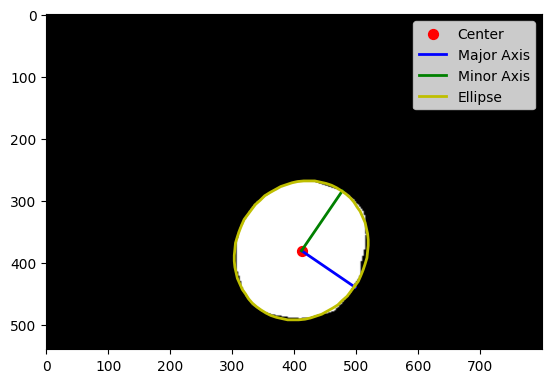

In [104]:
# Ensure there is at least one contour
if len(contours) > 0:
    # Approximate the contour to find the ellipse
    #((center_x, center_y), (major_axis_length, minor_axis_length), angle)
    ellipse = cv2.fitEllipse(contours[0])
    
    print( ellipse)
    
    # Extract values
    (center, axes, angle) = ellipse
    (center_x, center_y) = center
    major_axis_length, minor_axis_length = axes

    print("Center (x, y):", center_x, center_y)
    print("Major Axis Length:", major_axis_length)
    print("Minor Axis Length:", minor_axis_length)
    print("Angle (degrees):", angle)
    
    
    # Calculate the perimeter of the fitted ellipse
    #perimeter = cv2.arcLength(ellipse, True)
    
    # Extract values
    (center, axes, angle) = ellipse
    (center_x, center_y) = center
    major_axis_length, minor_axis_length = axes

    # Create a rotated ellipse using the parameters
    ellipseFit = cv2.ellipse2Poly((int(center_x), int(center_y)), (int(major_axis_length / 2), int(minor_axis_length / 2)), int(angle), 0, 360, 5)

    # Calculate the perimeter of the ellipse contour
    perimeter = cv2.arcLength(ellipseFit, True)

    print("Ellipse Perimeter pixels:", perimeter)
    
    dpi=96#144;
    tomm=25.4;
    scale=1/2;
    mmperimeter = scale*tomm*perimeter/dpi;
    print("Ellipse Perimeter mm:", mmperimeter)
    
    #===========
    # Plot the mask with the center and ellipse
    plt.figure()
    plt.imshow(maskr, cmap='gray')
    
    # Plot the center
    plt.scatter(center_x, center_y, c='red', marker='o', s=50, label='Center')
    
    # Plot the major axis
    plt.plot([center_x, center_x + major_axis_length / 2 * np.cos(np.radians(angle))],
             [center_y, center_y + major_axis_length / 2 * np.sin(np.radians(angle))],
             'b-', linewidth=2, label='Major Axis')
    
    # Plot the minor axis
    plt.plot([center_x, center_x - minor_axis_length / 2 * np.cos(np.radians(angle + 90))],
             [center_y, center_y - minor_axis_length / 2 * np.sin(np.radians(angle + 90))],
             'g-', linewidth=2, label='Minor Axis')
    
    # Plot the ellipse
    plt.plot(ellipseFit[:, 0], ellipseFit[:, 1], 'y-', linewidth=2, label='Ellipse')
    
    plt.legend()
   
else:
    print("No contours found.")

In [105]:
HC_df.iloc[0]
#actually dpi is 96

filename                   000_HC.png
pixel size(mm)               0.069136
head circumference (mm)          44.3
Name: 0, dtype: object

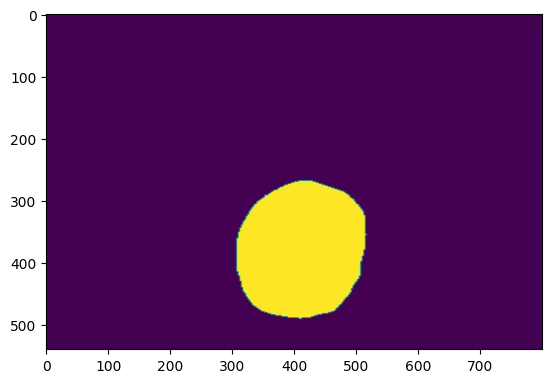

In [106]:
plt.figure()
plt.imshow(maskr)

In [107]:
def plotAndComputeElipse(mask,wImage,hImage,dpi=144):
    # plot ellipse on mask
    # estimate perimeter 
    # wimage,himage original image size
    
    maskr = cv2.resize(mask,(wImage,hImage))
    # Find contours in the binary image
    contours, _ = cv2.findContours(maskr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Ensure there is at least one contour
    if len(contours) > 0:
        # Approximate the contour to find the ellipse
        #((center_x, center_y), (major_axis_length, minor_axis_length), angle)
        ellipse = cv2.fitEllipse(contours[0])

        print( ellipse)

        # Extract values
        (center, axes, angle) = ellipse
        (center_x, center_y) = center
        major_axis_length, minor_axis_length = axes

        print("Center (x, y):", center_x, center_y)
        print("Major Axis Length:", major_axis_length)
        print("Minor Axis Length:", minor_axis_length)
        print("Angle (degrees):", angle)


        # Calculate the perimeter of the fitted ellipse
        #perimeter = cv2.arcLength(ellipse, True)
    
        # Extract values
        (center, axes, angle) = ellipse
        (center_x, center_y) = center
        major_axis_length, minor_axis_length = axes

        # Create a rotated ellipse using the parameters
        ellipseFit = cv2.ellipse2Poly((int(center_x), int(center_y)), (int(major_axis_length / 2), int(minor_axis_length / 2)), int(angle), 0, 360, 5)

        # Calculate the perimeter of the ellipse contour
        perimeter = cv2.arcLength(ellipseFit, True)

        print("Ellipse Perimeter pixels:", perimeter)

        #dpi=144;
        tomm=25.4;
        scale=1/2;
        mmperimeter = scale*tomm*perimeter/dpi;
        print("Ellipse Perimeter mm:", mmperimeter)

        #===========
        # Plot the mask with the center and ellipse
        plt.figure()
        plt.imshow(maskr, cmap='gray')

        # Plot the center
        plt.scatter(center_x, center_y, c='red', marker='o', s=50, label='Center')
    
        # Plot the major axis
        plt.plot([center_x, center_x + major_axis_length / 2 * np.cos(np.radians(angle))],
                 [center_y, center_y + major_axis_length / 2 * np.sin(np.radians(angle))],
                 'b-', linewidth=2, label='Major Axis')

        # Plot the minor axis
        plt.plot([center_x, center_x - minor_axis_length / 2 * np.cos(np.radians(angle + 90))],
                 [center_y, center_y - minor_axis_length / 2 * np.sin(np.radians(angle + 90))],
                 'g-', linewidth=2, label='Minor Axis')

        # Plot the ellipse
        plt.plot(ellipseFit[:, 0], ellipseFit[:, 1], 'y-', linewidth=2, label='Ellipse')

        plt.legend()
   
    else:
       print("No contours found.")

In [108]:
fname='/kaggle/input/fetal-head-thesis/training_set/training_set/000_HC.png'
image= cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
h,w = image.shape
hm,wm=mask1.shape

print(h,w,hm,wm)

540 800 320 320


540 800


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 540,
 800)

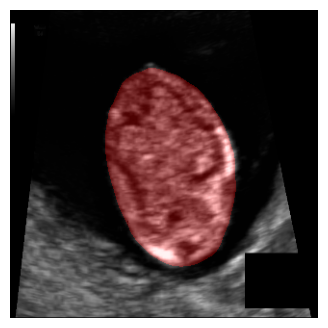

In [109]:
fname='/kaggle/input/fetal-head-thesis/training_set/training_set/013_HC.png'
runModelOnImage(model,fname,get_valid_augs())

# image1

1162 1602


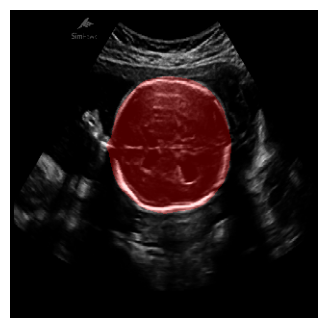

In [110]:
fname='/kaggle/input/headfc/TestSet/image_hc_104.jpg'
mask1,hImage1,wImage1  = runModelOnImage(model,fname,get_valid_augs())

((834.3472900390625, 510.2554016113281), (529.090576171875, 647.0458374023438), 88.9669418334961)
Center (x, y): 834.3472900390625 510.2554016113281
Major Axis Length: 529.090576171875
Minor Axis Length: 647.0458374023438
Angle (degrees): 88.9669418334961
Ellipse Perimeter pixels: 1848.4177780151367
Ellipse Perimeter mm: 163.02017903327942


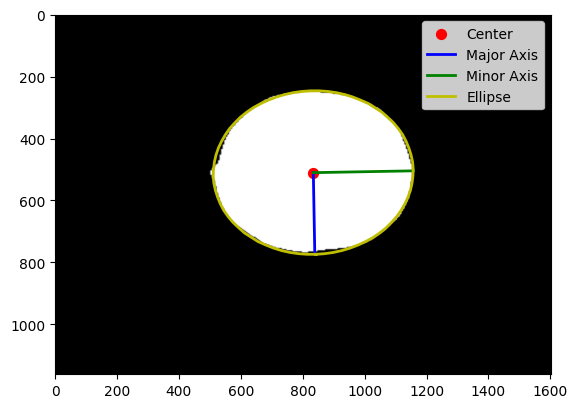

In [111]:
plotAndComputeElipse(mask1,wImage1,hImage1)

# image2

1172 1606


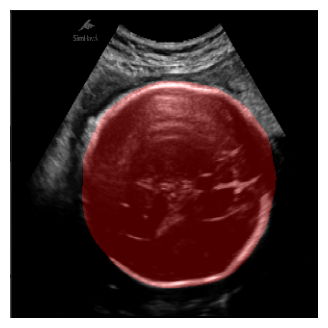

In [112]:
fname='/kaggle/input/headfc/TestSet/image_hc_17.jpg'
mask2,hImage2,wImage2  = runModelOnImage(model,fname,get_valid_augs())

((876.7496948242188, 662.552978515625), (802.0469360351562, 1026.0093994140625), 89.28994750976562)
Center (x, y): 876.7496948242188 662.552978515625
Major Axis Length: 802.0469360351562
Minor Axis Length: 1026.0093994140625
Angle (degrees): 89.28994750976562
Ellipse Perimeter pixels: 2881.685905456543
Ellipse Perimeter mm: 254.14868749512567


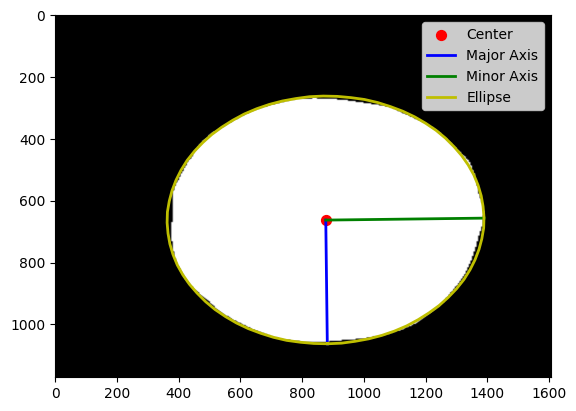

In [113]:
plotAndComputeElipse(mask2,wImage2,hImage2)

# image3

1166 1608


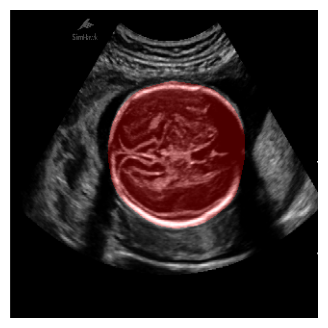

In [114]:
fname='/kaggle/input/headfc/TestSet/image_hc_30.jpg'
mask3,hImage3,wImage3 = runModelOnImage(model,fname,get_valid_augs())

((871.5631713867188, 541.9039916992188), (565.160888671875, 735.6790161132812), 90.33296203613281)
Center (x, y): 871.5631713867188 541.9039916992188
Major Axis Length: 565.160888671875
Minor Axis Length: 735.6790161132812
Angle (degrees): 90.33296203613281
Ellipse Perimeter pixels: 2047.367088317871
Ellipse Perimeter mm: 180.56640292803445


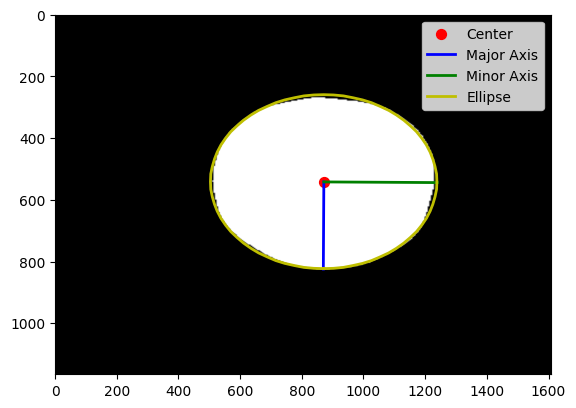

In [115]:
plotAndComputeElipse(mask3,wImage3,hImage3)

# image 4

1168 1606


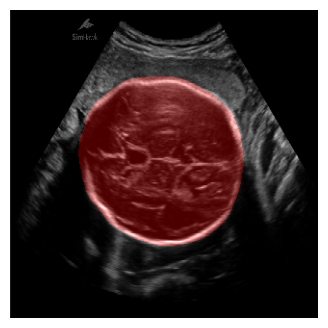

In [116]:
fname='/kaggle/input/headfc/TestSet/image_hc_7.jpg'
mask4,hImage4,wImage4 = runModelOnImage(model,fname,get_valid_augs())

((793.829345703125, 567.5149536132812), (651.1410522460938, 874.4129638671875), 95.73568725585938)
Center (x, y): 793.829345703125 567.5149536132812
Major Axis Length: 651.1410522460938
Minor Axis Length: 874.4129638671875
Angle (degrees): 95.73568725585938
Ellipse Perimeter pixels: 2406.2926483154297
Ellipse Perimeter mm: 212.22164328893027


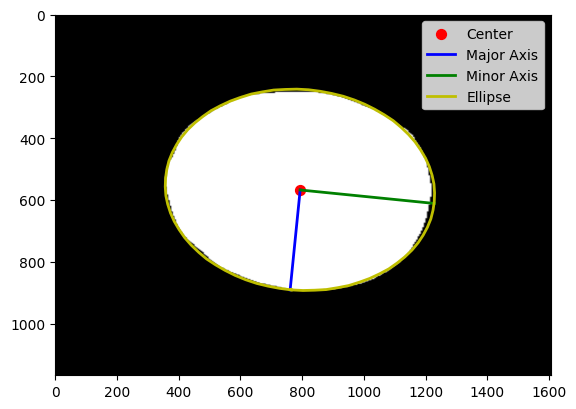

In [117]:
plotAndComputeElipse(mask4,wImage4,hImage4)